# Setup

In [4]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [5]:
from sparse_field_lib import load_data

In [6]:
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

In [7]:
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [26]:
device = torch.device('cuda:0')

# Load data

In [27]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [28]:
image, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [29]:
wcs = wcs_list[0]

In [30]:
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)

## Look at complete image

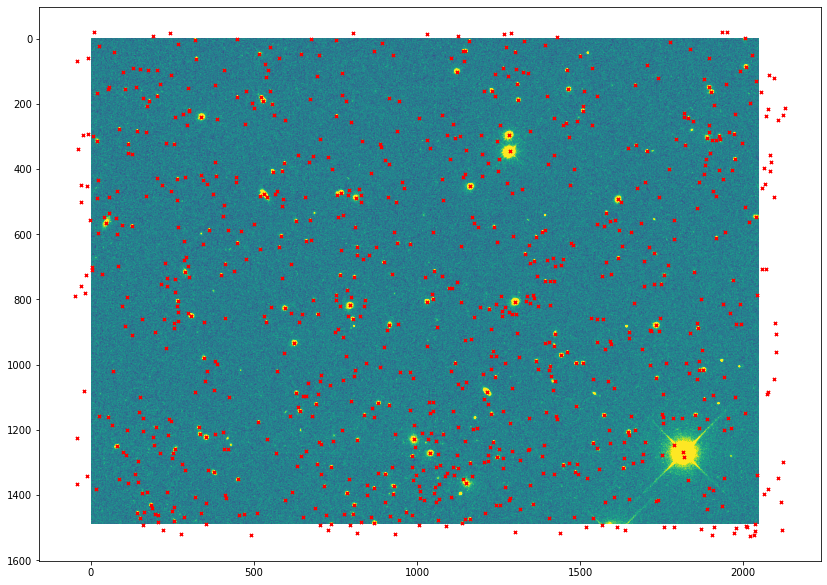

In [31]:
%matplotlib inline
plt.figure(figsize=(14,14))
vmin = np.percentile(image.flatten(), 1)
vmax = np.percentile(image.flatten(), 99)

plt.imshow(image[0], vmin=vmin, vmax=vmax)
plt.scatter(pt, pr, marker='x', color='r', s=10)


## choose one chunk

In [32]:
# prepare chunk
# i, j = np.random.randint(0, 6, size=(2))
# i,j = (1,5)
clen = 200
xlim = (450, 650)
ylim = (350, 550)
print(xlim, ylim)

chunk = image[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]

pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)

# restrict to 200x200 chunk 
keep = (pt > xlim[0]) & (pt < xlim[1]) & (pr < ylim[1]) & (pr > ylim[0])

# obtain star and galaxy bools for each location.
is_star = fits_file['probpsf'][:].astype(bool)
galaxy_bool = (~is_star) & keep
star_bool = is_star & keep

(450, 650) (350, 550)


In [33]:
# move image to device
slen = 200
chunks = chunk.reshape(1, 1, *chunk.shape)[:, :, :slen, :slen].to(device)
print(chunks.shape)

torch.Size([1, 1, 200, 200])


In [66]:
go.Scatter?

In [68]:
px.imshow?

In [98]:
import plotly.express as px
import plotly.graph_objects as go

# figure out colorbar and image ranges. 
p_level = 0.05
vmin = np.percentile(chunk.flatten(), p_level)
vmax = np.percentile(chunk.flatten(), 100-p_level)

# in plotly first you get a figure object
fig = px.imshow(chunk, zmin=vmin, zmax=vmax)

# now we want a scatter plot overlayed, we first create a scatter object as shown in the tutorial

 # account for bias
_pt = pt - xlim[0]
_pr = pr - ylim[0]

# one for galaxies, one for stars
scatter_galaxies = go.Scatter(name='galaxy', x=_pt[galaxy_bool], y=_pr[galaxy_bool], mode='markers', marker=dict(color='red', size=8, symbol='x'))
scatter_stars = go.Scatter(name='star', x=_pt[star_bool], y=_pr[star_bool], mode='markers', marker=dict(color='blue', size=8, symbol='x'))

fig.add_trace(scatter_galaxies)
fig.add_trace(scatter_stars)
fig.update_layout(width=650, height=650)
fig.show()

## get estimate from chunk

In [99]:
# read sleep 
checkpoint_file = '/home/imendoza/bliss/models/sleep_sdss_measure.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
image_encoder = image_encoder.eval()

In [100]:
with torch.no_grad():

    tile_est = sleep_net.tile_images_map_estimate(chunks)
    sleep_net.image_decoder.background_values = (633.0, )
    
    # plot image from tile est.
    recon_image, _ = sleep_net.image_decoder.render_images(
        tile_est["n_sources"],
        tile_est["locs"],
        tile_est["galaxy_bool"],
        tile_est["galaxy_params"],
        tile_est["fluxes"],
        add_noise=False,
    )
    
    _slen = chunks.shape[-1] - image_encoder.border_padding*2
    est_params = encoder.get_full_params(tile_est, _slen)

In [133]:
from plotly.subplots import make_subplots

# plot both images side by side.
_recon_image = recon_image.detach().cpu().numpy()[0, 0]

fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.01, shared_yaxes=True, shared_xaxes=True)

# get ranges. 
p = 0.1
combined = np.hstack([chunk.flatten(), _recon_image.flatten()])
vmin = np.percentile(combined, p)
vmax = np.percentile(combined, 100-p)

# add images
fig.add_trace(go.Heatmap(z=chunk, zmin=vmin, zmax=vmax), 1, 1)
fig.add_trace(go.Heatmap(z=_recon_image, zmin=vmin, zmax=vmax), 1, 2)

# scatter objects.
scatter_galaxies_true = go.Scatter(name='true_galaxy', x=_pt[galaxy_bool], y=_pr[galaxy_bool], mode='markers', marker=dict(color='red', size=8, symbol='x'))
scatter_stars_true = go.Scatter(name='true_star', x=_pt[star_bool], y=_pr[star_bool], mode='markers', marker=dict(color='orange', size=8, symbol='x'))

_locs = est_params['locs']*_slen + image_encoder.border_padding
_locs = _locs.detach().cpu().numpy()[0]
_galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
_prob_galaxy = est_params['prob_galaxy'].float().detach().cpu().numpy()[0, :, 0]

scatter_galaxies_est = go.Scatter(name='est_galaxy', x=_locs[:, 1][_galaxy_bool], y=_locs[:, 0][_galaxy_bool], 
                                  mode='markers', marker=dict(color='blue', size=8, symbol='cross'),
                                  hovertext=[f'prob_galaxy:{x:.2f}' for x in _prob_galaxy[_galaxy_bool]]
                                 )
scatter_stars_est = go.Scatter(name='est_star', x=_locs[:, 1][~_galaxy_bool], y=_locs[:, 0][~_galaxy_bool], 
                               mode='markers', marker=dict(color='cyan', size=8, symbol='cross'),
                              hovertext=[f'prob_galaxy:{x:.3f}' for x in _prob_galaxy[~_galaxy_bool]]
                              )

# add traces
fig.add_trace(scatter_galaxies_true, 1, 1)
fig.add_trace(scatter_stars_true, 1, 1)
fig.add_trace(scatter_galaxies_est, 1, 1)
fig.add_trace(scatter_stars_est, 1, 1)
fig.add_trace(scatter_galaxies_est, 1, 2)
fig.add_trace(scatter_stars_est, 1, 2)
fig.show()
